In [1]:
%pip install pykrige
%pip install xarray==2024.05.0

  Using cached PyKrige-1.7.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached PyKrige-1.7.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (979 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached xarray-2024.5.0-py3-none-any.whl.metadata (11 kB)
Using cached xarray-2024.5.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.4.0
    Uninstalling xarray-2025.4.0:
      Successfully uninstalled xarray-2025.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xmip 0.7.2 requires cf_xarray>=0.6.0, which is not installed.
xmip 0.7.2 requires xarrayutils, which is not installed.
xmip 0.7.2 requires xgcm<0.7.0, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib widget

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from skimage import exposure
from skimage.io import imsave, imread
from osgeo import ogr
import pystac_client
from pyproj import Transformer
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
import geopandas as gpd
import pandas as pd
import geoviews as gv
import hvplot.pandas
import intake
import xarray as xr
import numpy as np
from numpy.random import default_rng
import intake
from pyproj import Proj, transform
from osgeo import gdal
from sklearn.neighbors import BallTree
import earthaccess
import gzip

# for progress bar
from ipywidgets import IntProgress
from IPython.display import display
from ipywidgets import interact, Dropdown
import time
from tqdm.notebook import trange, tqdm

import boto3
import rasterio as rio
from rasterio.features import rasterize
from rasterio.session import AWSSession
import dask
import os
import rioxarray
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.warp import Resampling as resample
import cartopy.crs as ccrs
import cartopy
from pykrige.ok import OrdinaryKriging
from sklearn.linear_model import LinearRegression, RANSACRegressor
from scipy.odr import Model, RealData, ODR
import scipy.odr as odr
import scipy
import statsmodels.formula.api as smf
from shapely.geometry.polygon import Polygon, Point
import pygmt
import gc
import pytz
import pyproj
import math
from pathlib import Path
from matplotlib.patches import Polygon as Pgon
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

import SSTutils as sut

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Coefficients for calibration
calib_m = 0.76 
calib_b = 0.55

# Create validation matchups via GHRSST iQUAM data
https://www.star.nesdis.noaa.gov/socd/sst/iquam/?tab=0&dateinput_year=2023&dateinput_month=02&dayofmoninput_day=26&dateinput_hour=00&dayofmon=monthly&qcrefsst=_qcrey&qcrefsst=_qccmc&outlier=qced#qmap

In [3]:
# Landsat STAC catalog location
url = 'https://landsatlook.usgs.gov/stac-server'

# Paths
basepath = Path('/home/jovyan/Landsat_SST_algorithm')
lsatpath = basepath / 'Data'
atmpath = lsatpath / 'AtmCorrection'
modout_path = lsatpath / 'MOD07_L2'
SSTpath = lsatpath / 'SST/Validation/iQuamIntercomp/'
iQpath = lsatpath / 'iQuam'

WV = 'Water_Vapor'

# For geopandas and tile plots
satellite = 'Landsat8'
collection = 'landsat-c2l1' # Landsat Collection 2, Level 1
colnm = ['landsat:wrs_path','landsat:wrs_row']
gjson_outfile = lsatpath / f'{satellite}_iQuam.geojson'

# Buffer around iquam point used to create a bounding box for Landsat sample
dist = 1.0 # km

# Temporal search range (days) before/after iquam measurement for finding Landsat image
time_add = 0.5

lthresh = -1.9

interp = 1

In [4]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")

# If we are not authenticated
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

In [5]:
# Authenticate for boto S3 access, etc.
os.environ["AWS_REQUEST_PAYER"] = "requester"
aws_session = AWSSession(boto3.Session(), requester_pays=True)

In [6]:
# Setup and authenticate 
from dask.distributed import Client
import logging
client = Client(processes=True, n_workers=4, 
                threads_per_worker=1,
                silence_logs=logging.ERROR)
client.run(lambda: os.environ["AWS_REQUEST_PAYER"] == "requester" )
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/tsnow03/proxy/44861/status,
Dashboard: /user/tsnow03/proxy/44861/status,Workers: 4
Total threads: 4,Total memory: 29.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42203,Workers: 0
Dashboard: /user/tsnow03/proxy/44861/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36261,Total threads: 1
Dashboard: /user/tsnow03/proxy/39253/status,Memory: 7.42 GiB
Nanny: tcp://127.0.0.1:42553,


In [7]:
# Year and months desired (multiple years)
start_yr = 2013
end_yr = 2023

# Note these will get months from the later part of the year to early next
start_mo = '09'
end_mo = '03'

# Headers for the saved outputs
headers = ['DateTime','L8_filename','L8_SST','L8_std','center','N','S','E','W','NE','SE','NW','SW','L8_SST_max','L8_SST_min','Argo_id','Argo_SST','A_lat','A_lon']

# Desired projection transformation
source_crs = 'epsg:4326' 
target_crs = 'epsg:3031' # Coordinate system of the Landsat file

In [8]:
# # Create scalar for normalizing T, TOA, and WV data
months = ['01','02','03','04','05','06','07','08','09','10','11','12']

modtran_lut,n = sut.concat_modtran_months(months,atmpath)

simTOA = modtran_lut[['TOA T[K]']]
simWV = modtran_lut[['TCWV [cm]']]
# simT = modtran_lut[['Surface T[K]']] # Decided this was skewed because of Andy's forcings so use TOA scaler instead
simT = simTOA.rename(columns={'TOA T[K]': 'Surface T[K]'})

print(f'ERA5 count: {n}')
print(f'Simulated TOA min: {np.around(simTOA.min().values[0],2)}, and max: {np.around(simTOA.max().values[0],2)}')
print(f'Simulated WV min: {np.around(simWV.min().values[0],4)}, and max: {np.around(simWV.max().values[0],5)}')
print(f'Simulated SST min: {np.around(simT.min().values[0],2)}, and max: {np.around(simT.max().values[0],2)}')

simTOA_transformer = StandardScaler().fit(simTOA)
simWV_transformer = StandardScaler().fit(simWV)
# simT_transformer = RobustScaler().fit(simT)
simT_transformer = StandardScaler().fit(simT) # This is using TOA at the moment until get updated TOA

01: 1175
02: 1417
03: 1417
04: 1145
05: 958
06: 605
07: 515
08: 712
09: 327
10: 315
11: 314
12: 772
ERA5 count: 9672
Simulated TOA min: 270.17, and max: 275.18
Simulated WV min: 0.037, and max: 2.0716
Simulated SST min: 270.17, and max: 275.18


In [9]:
# Derive coefficients for SST retrievals
atmcor,retrieval_results,modtran_lut_norm = sut.derive_coeffs(atmpath,simTOA_transformer,simWV_transformer,simT_transformer)

Processing rolling window for middle month 01
12: 772
01: 1175
02: 1417
Rolling for month 01: toa = 1.08, tcwv_toa = -0.02, Intercept = 0.96, R2 = 0.98
p-values for month 01: toa = 0.0, tcwv_toa = 0.0, Intercept = 0.0
Processing rolling window for middle month 02
01: 1175
02: 1417
03: 1417
Rolling for month 02: toa = 1.08, tcwv_toa = -0.01, Intercept = 0.96, R2 = 0.98
p-values for month 02: toa = 0.0, tcwv_toa = 0.011, Intercept = 0.0
Processing rolling window for middle month 03
02: 1417
03: 1417
04: 1145
Rolling for month 03: toa = 1.07, tcwv_toa = 0.01, Intercept = 0.99, R2 = 0.99
p-values for month 03: toa = 0.0, tcwv_toa = 0.007, Intercept = 0.0
Processing rolling window for middle month 04
03: 1417
04: 1145
05: 958
Rolling for month 04: toa = 1.06, tcwv_toa = 0.01, Intercept = 0.99, R2 = 0.98
p-values for month 04: toa = 0.0, tcwv_toa = 0.0, Intercept = 0.0
Processing rolling window for middle month 05
04: 1145
05: 958
06: 605
Rolling for month 05: toa = 1.05, tcwv_toa = -0.0, In

In [10]:
%%time

# Multiple years

# Set up projections
transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)

# Get iQuam file paths in directory between desired dates and find and produce matching Landsat SSTs 
for year in range(start_yr, end_yr):  
    yrmo = []
    start_yrmo = f"{year}{start_mo}"  # Start from September of the current year
    end_yrmo = f"{year+1}{end_mo}"  # End in March of the next year

    m0 = start_yrmo
    
    # Make a list of months between start and end
    while int(m0) <= int(end_yrmo):
        calc_dt = datetime.strptime(f'{m0[:4]}-{m0[4:]}', '%Y-%m')
        yrmo.append(calc_dt.strftime("%Y%m"))
        m0 = (calc_dt + relativedelta(months=1)).strftime("%Y%m")
    
    # Get file names and select only those matching dates from yrmo    
    iQfiles = os.listdir(iQpath)
    iQfiles = [x for x in iQfiles if x[:6] in yrmo]
    iQfiles.sort(reverse=True)
    print (f'{year}: {len(iQfiles)}')
    
    os.chdir(iQpath)

    # For each iquam file, pair West Antarctic Argo buoy data with Landsat data and create calibrated SSTs
    valid = []
    
    for iquam_file in iQfiles:
        # Open Argos data from iQuam file
        df = xr.open_dataset(iquam_file)
        iquam = df.to_dataframe()
        
        # Subset to Antarctica
        ant = iquam[(iquam.lat<-65)&(iquam.lon>-142)&(iquam.lon<-72)&(iquam.platform_type==5.0)&(iquam.quality_level==5.0)]  # Entire West Antarctica (later)
        # ant = iquam[(iquam.lat<-69)&(iquam.lon>-125)&(iquam.lon<-98)&(iquam.platform_type==5.0)&(iquam.quality_level==5.0)] # Amundsen Sea
        
        # To remove a landsat day that is coming up with a 403 error
        if ant['year'].iloc[0] == 2020 and ant['month'].iloc[0] == 12:
            ant = ant[ant.day != 9.0] # for 202012 because otherwise will fail
        
        print('')
        print(f'{iquam_file[:6]}: {ant.shape[0]} measurements')
    
        for idx in tqdm(range(ant.shape[0]), desc="Processing"):
    
            # Create search area
            ilat = ant['lat'].iloc[idx]
            ilon = ant['lon'].iloc[idx]
    
            lat_add = sut.km_to_decimal_degrees(dist, ilat, direction='latitude')
            lon_add = sut.km_to_decimal_degrees(dist, ilat, direction='longitude')
            bboxV = (ilon-lon_add,ilat-lat_add,ilon+lon_add,ilat+lat_add)
    
            # Create Landsat temporal search range in correct format
            ihr = int(ant.hour.iloc[idx])
            iyr = int(ant.year.iloc[idx])
            imo = int(ant.month.iloc[idx])
    
            calc_dt = datetime.strptime(f'{iyr}-{imo}-{int(ant.day.iloc[idx])} {ihr}', '%Y-%m-%d %H')
            start_dt = (calc_dt + timedelta(days=-time_add)).strftime('%Y-%m-%dT%H:%M:%SZ')
            end_dt = (calc_dt + timedelta(days=time_add)).strftime('%Y-%m-%dT%H:%M:%SZ')
    
            timeRangeV = f'{start_dt}/{end_dt}'
    
            # Search for desired Landsat scenes
            items = sut.search_stac(url,collection,gjson_outfile=gjson_outfile,bbox=bboxV,timeRange=timeRangeV)
    
            # Load the geojson file and open stac catalog
            catalog = intake.open_stac_item_collection(items)
            gf = gpd.read_file(gjson_outfile)
    
            # Exclude Landsat 9
            catalog_list = [x for x in items if x.id[3]=='8']
            num_scene = len(catalog_list)
            # print(f'{num_scene} Landsat 8 items')
    
            # If any matching landsat scenes are found create calibrated SSTs for them
            if num_scene>0:
    
                # Reproject to determine bounding box in espg 3031
                sbox,checkbox = sut.lsat_reproj(source_crs,target_crs,(bboxV[0],bboxV[1],bboxV[2],bboxV[3]))
    
                # Create polygon for later cropping
                polygon = Polygon([(sbox[0][0],sbox[0][1]),(sbox[3][0],sbox[3][1]),(sbox[2][0],sbox[2][1]),(sbox[1][0],sbox[1][1])])
                
                # Create min/max boundaries for trimming image before crop_xarray to cut down on processing times
                minx, miny, maxx, maxy = polygon.bounds
                polarx = [minx, maxx]
                polary = [miny, maxy]
    
                # Create calibrated SSTs for each matching landsat scene
                for sceneid in catalog_list:
                    print(sceneid.id)
    
                    scene = catalog[sceneid.id]
                    timestr = scene.metadata['datetime'].strftime('%H%M%S')
    
                    outFile = f'{SSTpath}/{sceneid.id}_{timestr}_Cel.tif'
    
                    if os.path.isfile(outFile):
                        print (f'{sceneid.id} - atm corr exists')
                        ls_scene = xr.open_dataset(outFile,chunks=dict(x=512, y=512),engine='rasterio')
                        ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)
    
                        # Subset all scenes and check for right dimensions because y order changes sometimes
                        ls_sub = sut.subset_img(ls_scene['band_data'].sel(band=1),polarx,polary) # subset so easier to work with
    
                    else:
                        # try:
                        # Open all desired bands for one scene
                        ls_scene = sut.landsat_to_xarray(sceneid,catalog)
                        ls_scene = ls_scene.rio.write_crs("epsg:3031", inplace=True)
        
                        # Create classification mask
                        ls_scene = sut.create_masks(ls_scene, cloud_mask=True, ice_mask=True, ocean_mask=True)

                        # Check for any open ocean pixels - go to next image if none - ??? s
                        mask = np.ones(ls_scene.shape[1:])
                        mask[ls_scene.mask!=3] = np.nan
                        ls_thermal = ls_scene.sel(band='lwir11').compute()

                        # Check in bounding box or for entire Landsat image depending on whether doing calibration runs or not
                        ls_box = sut.subset_img(ls_thermal*mask,polarx,polary)

                        if ((ls_box).notnull()).sum().values==0:
                            print (f'{sceneid.id} has no SSTs')
                            try:
                                del ls_scene, scene, mask, ls_thermal, ls_box
                            except:
                                pass
                            gc.collect()
                            continue

                        # Use band ratios for RF cloud pixel classification
                        ####

                        # Atmospheric correction using MODIS
                        # Acquire and align MODIS water vapor (MOD/MYD07) to Landsat
                        mod07,modfilenm = sut.open_MODIS(ls_scene,scene,modout_path)
                        print("1")

                        # Create water vapor files aligned and subsampled to Landsat
                        spacing = [300,-300] # 300m sampling of MODIS data so that upsampling is easy and because 30m takes far too long
                        WV_xr = sut.get_wv(ls_scene,mod07,spacing,WV,scene,interp=interp)
                        print("2")
                        # Create SST by masking and using water vapor to apply atmospheric correction
                        SST = sut.apply_retrieval(ls_thermal,scene,mask,WV_xr,atmcor,simT_transformer,simTOA_transformer,simWV_transformer)

                        # Record MODIS water vapor image used in atmospheric correction, will find this info save under band_data in
                        # data variables in COG (click on white paper info button in xarray readout)
                        SST.attrs['MODIS_WV'] = modfilenm

                        # Save to a cloud-optimized Geotiff
                        SST.rio.to_raster(raster_path=outFile, driver="COG")
                        print (f'Mean SST: {np.nanmean(SST)}')

                        # Subset all scenes and check for right dimensions because y order changes sometimes
                        ls_sub = sut.subset_img(SST,polarx,polary) # subset so easier to work with 

                        try:
                            del mask, ls_thermal, mod07, WV_xr, SST
                        except:
                            pass
    
                        # except Exception as e:
                        #     print (sceneid.id, e)
                        #     lsat = np.nan
                        #     lstd = np.nan
    
                    # Crop data to exact bounding box
                    ls_sub = sut.crop_xarray_dataarray_with_polygon(ls_sub, polygon) 
    
                    # Calibrate using MODIS
                    ls_sub = ls_sub * calib_m + calib_b
    
                    # Remove all pixels that are too cold
                    ls_sub = ls_sub.where(ls_sub>=lthresh,np.nan)
    
                    lsat = np.around(np.nanmean(ls_sub),2)
                    lstd = np.around(np.nanstd(ls_sub),2)
    
                    # Convert Argo lat/lon to Landsat's EPSG:3031
                    argo_px, argo_py = transformer.transform(ilon, ilat)
    
                    # 1) Find the nearest center pixel
                    center_val = ls_sub.sel(x=argo_px, y=argo_py, method="nearest")
                    
                    # Extract the x/y coordinate values as plain floats
                    center_x = center_val.x.item()
                    center_y = center_val.y.item()
                    
                    # 2) Get integer indices from the coordinate indexes
                    #    This uses ls_sub.get_index('dim_name') -> pandas.Index -> get_indexer(...)
                    center_x_idx = ls_sub.get_index("x").get_indexer([center_x])[0]
                    center_y_idx = ls_sub.get_index("y").get_indexer([center_y])[0]
                    
                    # 3) Gather offsets for the 3x3 neighborhood
                    offsets = [
                        ( 0,  0, "center"),
                        ( 0,  1, "N"),
                        ( 0, -1, "S"),
                        ( 1,  0, "E"),
                        (-1,  0, "W"),
                        ( 1,  1, "NE"),
                        ( 1, -1, "SE"),
                        (-1,  1, "NW"),
                        (-1, -1, "SW"),
                    ]
                    
                    neighbors = {}
                    for dx, dy, name in offsets:
                        nx = center_x_idx + dx
                        ny = center_y_idx + dy
                        # Ensure we're within the array bounds
                        if (0 <= nx < ls_sub.sizes['x']) and (0 <= ny < ls_sub.sizes['y']):
                            # xarray dimension order is typically (y, x), so use isel(y=ny, x=nx):
                            neighbors[name] = ls_sub.isel(y=ny, x=nx).values.item()
                        else:
                            neighbors[name] = np.nan
                    
                    # 4) Record coincident data from Landsat and Argo float
                    argo_temp = np.around((ant.sst.iloc[idx] - 273.15),2)  # convert to Celsius
                    times = pd.to_datetime(calc_dt, format='%Y%m%d%H')  # standardize time
                    
                    valid.append([
                        times,
                        sceneid.id,
                        lsat,
                        lstd,
                        neighbors['center'],
                        neighbors['N'],
                        neighbors['S'],
                        neighbors['E'],
                        neighbors['W'],
                        neighbors['NE'],
                        neighbors['SE'],
                        neighbors['NW'],
                        neighbors['SW'],
                        ls_sub.max().values.item(),
                        ls_sub.min().values.item(),
                        ant.iloc[idx].name,  # Argo ID or whichever label you prefer
                        argo_temp,
                        ilat,
                        ilon
                    ])
                    print (f'Argo temp: {argo_temp}, Landsat 8 mean: {lsat}+/-{lstd}')
    
                    try:
                        del ls_scene, scene, ls_thermal, ls_box, mod07, WV_xr, SST, ls_sub, neighbors
                    except:
                        pass
    
                    gc.collect()

    # Put data into DataFrame and save    
    lsat_mod_df = pd.DataFrame(valid,columns=headers)
    out_df = lsatpath / f'Landsat_validation_20250205_{start_yrmo}_{end_yrmo}_{dist}.csv'
    lsat_mod_df.to_csv(out_df)

2015: 7


Processing:   0%|          | 0/7 [00:00<?, ?it/s]


201603: 34 measurements


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_033109_20160326_20200907_02_T2
LC08_L1GT_033109_20160326_20200907_02_T2 has no SSTs


Processing:  14%|█▍        | 1/7 [00:49<04:58, 49.76s/it]


201602: 22 measurements


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_026111_20160206_20201016_02_T2
LC08_L1GT_026111_20160206_20201016_02_T2 has no SSTs


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_027111_20160213_20201016_02_T2
22 TOTAL granules
A granule has a problematic polygon that likely crosses the International DateLine
TopologyException: side location conflict at -50.835387607489182 -73.058300858293279. This can occur if the input geometry is invalid.
5 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 01:03:20


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 4650 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


1
2
Mean water vapor value is: 0.38719677551767206, min: 0.33422, max: 0.48941
Mean SST: -2.053995184797424
Argo temp: -0.53, Landsat 8 mean: -1.73+/-0.09


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_029110_20160227_20201016_02_T2
LC08_L1GT_029110_20160227_20201016_02_T2 has no SSTs


Processing:  29%|██▊       | 2/7 [04:01<11:05, 133.03s/it]


201601: 26 measurements


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_030110_20160101_20201016_02_T2
LC08_L1GT_030110_20160101_20201016_02_T2 has no SSTs
LC08_L1GT_030109_20160101_20201016_02_T2
LC08_L1GT_030109_20160101_20201016_02_T2 has no SSTs


Processing:  43%|████▎     | 3/7 [05:13<07:02, 105.55s/it]


201512: 20 measurements


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_027110_20151211_20201016_02_T2
23 TOTAL granules
A granule has a problematic polygon that likely crosses the International DateLine
TopologyException: side location conflict at -51.772819818933527 -72.973742887109836. This can occur if the input geometry is invalid.
A granule has a problematic polygon that likely crosses the International DateLine
6 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 01:03:34


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 3275 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


1
2
Mean water vapor value is: 0.595911922096498, min: 0.43322, max: 0.77645
Mean SST: -2.2460733409997307
Argo temp: -1.76, Landsat 8 mean: -1.06+/-0.12


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_028110_20151218_20201016_02_T2
LC08_L1GT_028110_20151218_20201016_02_T2 has no SSTs


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_029110_20151225_20201016_02_T2
LC08_L1GT_029110_20151225_20201016_02_T2 has no SSTs


Processing:  57%|█████▋    | 4/7 [08:05<06:35, 131.79s/it]


201511: 15 measurements


Processing:  71%|███████▏  | 5/7 [08:17<02:56, 88.30s/it] 


201510: 21 measurements


Processing:  86%|████████▌ | 6/7 [08:30<01:02, 62.67s/it]


201509: 23 measurements


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_029109_20150904_20200908_02_T2
LC08_L1GT_029109_20150904_20200908_02_T2 has no SSTs


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_030109_20150911_20200908_02_T2
LC08_L1GT_030109_20150911_20200908_02_T2 has no SSTs


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_031109_20150918_20200908_02_T2
LC08_L1GT_031109_20150918_20200908_02_T2 has no SSTs


Processing: 100%|██████████| 7/7 [10:03<00:00, 86.22s/it]


2016: 7


Processing:   0%|          | 0/7 [00:00<?, ?it/s]


201703: 70 measurements


Processing:  14%|█▍        | 1/7 [00:22<02:15, 22.62s/it]


201702: 65 measurements


Processing:  29%|██▊       | 2/7 [00:42<01:44, 20.86s/it]


201701: 68 measurements


Processing:  43%|████▎     | 3/7 [01:02<01:22, 20.65s/it]


201612: 26 measurements


Processing:  57%|█████▋    | 4/7 [01:15<00:52, 17.65s/it]


201611: 31 measurements


Processing:  71%|███████▏  | 5/7 [01:28<00:32, 16.05s/it]


201610: 32 measurements


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_003109_20161002_20201016_02_T2
LC08_L1GT_003109_20161002_20201016_02_T2 has no SSTs


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_029109_20161008_20201016_02_T2
LC08_L1GT_029109_20161008_20201016_02_T2 has no SSTs


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_030109_20161015_20201016_02_T2
LC08_L1GT_030109_20161015_20201016_02_T2 has no SSTs


Processing:  86%|████████▌ | 6/7 [03:04<00:43, 43.13s/it]


201609: 32 measurements


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_025110_20160910_20200906_02_T2
LC08_L1GT_025110_20160910_20200906_02_T2 has no SSTs


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_007109_20160912_20200906_02_T2
LC08_L1GT_007109_20160912_20200906_02_T2 has no SSTs


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_026110_20160917_20200906_02_T2
LC08_L1GT_026110_20160917_20200906_02_T2 has no SSTs


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_027110_20160924_20200906_02_T2
LC08_L1GT_027110_20160924_20200906_02_T2 has no SSTs
LC08_L1GT_027109_20160924_20201016_02_T2
LC08_L1GT_027109_20160924_20201016_02_T2 has no SSTs


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_027110_20160908_20200906_02_T2
LC08_L1GT_027110_20160908_20200906_02_T2 has no SSTs
LC08_L1GT_027109_20160908_20200906_02_T2
LC08_L1GT_027109_20160908_20200906_02_T2 has no SSTs


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_028110_20160915_20200906_02_T2
LC08_L1GT_028110_20160915_20200906_02_T2 has no SSTs
LC08_L1GT_028109_20160915_20200906_02_T2
LC08_L1GT_028109_20160915_20200906_02_T2 has no SSTs


Skipping field instruments: unsupported OGR type: 5
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 1


LC08_L1GT_029109_20160922_20200906_02_T2
21 TOTAL granules
A granule has a problematic polygon that likely crosses the International DateLine
TopologyException: side location conflict at -85.884842109341747 -70.747840932844213. This can occur if the input geometry is invalid.
5 TOTAL granules w overlap
Time difference between MODIS and Landsat: 0 days 00:33:31


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.
surface [WARNING]: 7035 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


1
2
Mean water vapor value is: 0.213726800100541, min: 0.17918, max: 0.26361
Mean SST: -8.387330527216223
Argo temp: -1.83, Landsat 8 mean: nan+/-nan


Processing: 100%|██████████| 7/7 [09:23<00:00, 80.55s/it] 

CPU times: user 9min 17s, sys: 1min 13s, total: 10min 30s
Wall time: 19min 27s



2025-06-20 00:01:26,484 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.11/asyncio/base_events.py", line 654, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/nanny.py", line 985, in run
    await worker.finished()
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/core.py", line 494, in finished
    await self._event_finished.wait()
  File "/srv/conda/envs/notebook/lib/python3.11/asyncio/locks.py", line 213, in wait
    await fut
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most rec

## Check Landsat SST output

In [55]:
Lfile = '/home/jovyan/Landsat_SST_algorithm/Data/SST/Validation/LC08_L1GT_228108_20200123_20201016_02_T2_141253_Cel.tif'
ls_scene = xr.open_dataset(Lfile)
ls_scene

<xarray.Dataset>
Dimensions:      (band: 1, x: 9081, y: 9101)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -2.495e+06 -2.495e+06 ... -2.223e+06 -2.223e+06
  * y            (y) float64 5.046e+05 5.046e+05 ... 2.316e+05 2.316e+05
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float64 ...

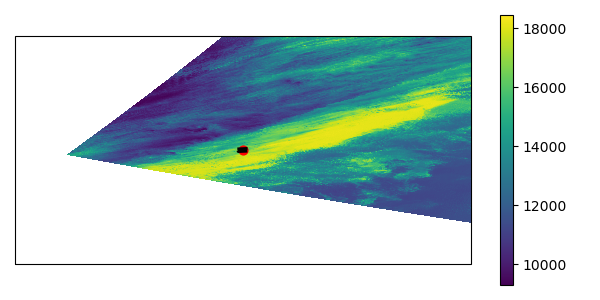

In [18]:
plt.figure(figsize=(6, 3))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.set_ylim([ilat-1,ilat+1])
ax.set_xlim([ilon-2,ilon+2])
cb = ax.pcolormesh(ls_scene.x,ls_scene.y,ls_scene.sel(band=1).to_array().isel(variable=0),transform=cartopy.crs.epsg(3031))
plt.scatter([ilon],[ilat],c='r',s=40,transform=ccrs.PlateCarree())
plt.plot([polarx[0],polarx[0],polarx[1],polarx[1],polarx[0]],[polary[0],polary[1],polary[1],polary[0],polary[0]],lw=2,ls='--',color='k',transform=cartopy.crs.epsg(3031))
ax.coastlines()
plt.colorbar(cb)
plt.tight_layout()

**Note the bands you would like to include are assigned by passing the bandNames parameter to landsat_to_xarray using the following codes:**

'coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'pan', 'cirrus', 'lwir11', 'lwir12', 'qa_pixel'

# Landsat-iQUAM validation assessment

In [10]:
# Read in processed matchups

# 20250107 is threshold=-1.9, 20250114 is thresh=-1.94, 20250205 is thresh=-1.9
out_df = lsatpath / 'Landsat_validation_202209_202303_1.0.csv'
df1 = pd.read_csv(out_df)
out_df = lsatpath / 'Landsat_validation_202109_202203_1.0.csv'
df2 = pd.read_csv(out_df)
out_df = lsatpath / 'Landsat_validation_202009_202103_1.0.csv'
df3 = pd.read_csv(out_df)
out_df = lsatpath / 'Landsat_validation_201909_202003_1.0.csv'
df4 = pd.read_csv(out_df)
out_df = lsatpath / 'Landsat_validation_201809_201903_1.0.csv'
df5 = pd.read_csv(out_df)
out_df = lsatpath / 'Landsat_validation_201709_201803_1.0.csv'
df6 = pd.read_csv(out_df)
out_df = lsatpath / 'Landsat_validation_201609_201703_1.0.csv'
df7 = pd.read_csv(out_df)
out_df = lsatpath / 'Landsat_validation_201509_201603_1.0.csv'
df8 = pd.read_csv(out_df)
out_df = lsatpath / 'Landsat_validation_201409_201503_1.0.csv'
df9 = pd.read_csv(out_df)
out_df = lsatpath / 'Landsat_validation_201309_201403_1.0.csv'
df10 = pd.read_csv(out_df)

valids = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]) 

valids = valids.set_index('DateTime')
valids = valids.sort_index()
valids['Argo_id'] = valids['Argo_id'].astype(int)

# Remove the non-numeric column for calculating daily means
numeric_valids = valids.select_dtypes(include=[np.number])
validmn = numeric_valids.groupby(numeric_valids['Argo_id']).mean()
valids = valids.reset_index()

# Group by the date component of the datetime and calculate the difference
valids['temp_dif'] = valids.groupby(valids['Argo_id'])[f'L8_SST'].diff()
validmn['temp_dif'] = valids.groupby(valids['Argo_id'])['temp_dif'].first()
valids = valids.set_index('DateTime')

validmn['std'] = valids.groupby([valids['Argo_id']])[f'L8_SST'].std()
validmn['xaxis'] = pd.to_datetime(validmn.index).dayofyear
validmn['xaxis'][validmn['xaxis']<(365/2)] = validmn['xaxis'] + 365

valids['xaxis'] = pd.to_datetime(valids.index).dayofyear
valids['xaxis'][valids['xaxis']<(365/2)] = valids['xaxis'] + 365

validmn = validmn.dropna(subset=['L8_SST'])

valids

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/Landsat_SST_algorithm/Data/Landsat_validation_202209_202303_1.0'

## Visualize all validation matchups for manual QC

In [29]:
# Setup and authenticate 
from dask.distributed import Client
import logging
client = Client(processes=True, n_workers=4, 
                threads_per_worker=1,
                silence_logs=logging.ERROR)
client.run(lambda: os.environ["AWS_REQUEST_PAYER"] == "requester" )
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/tsnow03/proxy/33263/status,
Dashboard: /user/tsnow03/proxy/33263/status,Workers: 4
Total threads: 4,Total memory: 29.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42459,Workers: 4
Dashboard: /user/tsnow03/proxy/33263/status,Total threads: 4
Started: Just now,Total memory: 29.67 GiB
Comm: tcp://127.0.0.1:33921,Total threads: 1
Dashboard: /user/tsnow03/proxy/43073/status,Memory: 7.42 GiB
Nanny: tcp://127.0.0.1:45663,


In [47]:
os.chdir(SSTpath)
lsatfiles = os.listdir(SSTpath)
lsatfiles = [i for i in lsatfiles if i[0]=='L']

# Remove all files from the list with repeats and Landsat mean = nan
remove = [
'LC08_L1GT_029109_20160922_20200906_02_T2', 
'LC08_L1GT_022110_20181029_20201016_02_T2', 
'LC08_L1GT_005110_20181209_20201016_02_T2',
'LC08_L1GT_228108_20200123_20201016_02_T2',
'LC08_L1GT_001108_20200929_20201006_02_T2',
'LC08_L1GT_002109_20201022_20201105_02_T2',
'LC08_L1GT_233108_20201109_20210317_02_T2',
'LC08_L1GT_233109_20201109_20210317_02_T2',
'LC08_L1GT_001109_20201202_20210312_02_T2',
'LC08_L1GT_027112_20220128_20220204_02_T2',
'LC08_L1GT_002109_20210331_20210408_02_T2'
]

lsatfiles = [i for i in lsatfiles if i[:-15] not in remove]
if len(lsatfiles)!=12:
    print('Wrong number of Landsat scenes!!!')

LC08_L1GT_026112_20220310_20220321_02_T2_172555_Cel.tif
LC08_L1GT_008109_20220107_20220114_02_T2_153344_Cel.tif
LC08_L1GT_002108_20210331_20210408_02_T2_145547_Cel.tif
LC08_L1GT_009109_20200329_20200822_02_T2_153924_Cel.tif
LC08_L1GT_029110_20200309_20201016_02_T2_174335_Cel.tif
LC08_L1GT_006109_20200221_20201016_02_T2_152108_Cel.tif
LC08_L1GT_226108_20190223_20201016_02_T2_140006_Cel.tif
LC08_L1GT_005109_20181209_20201016_02_T2_151450_Cel.tif
LC08_L1GT_228108_20180101_20201016_02_T2_141254_Cel.tif
LC08_L1GT_023110_20180121_20201016_02_T2_170636_Cel.tif
LC08_L1GT_027111_20160213_20201016_02_T2_173140_Cel.tif
LC08_L1GT_027110_20151211_20201016_02_T2_173126_Cel.tif


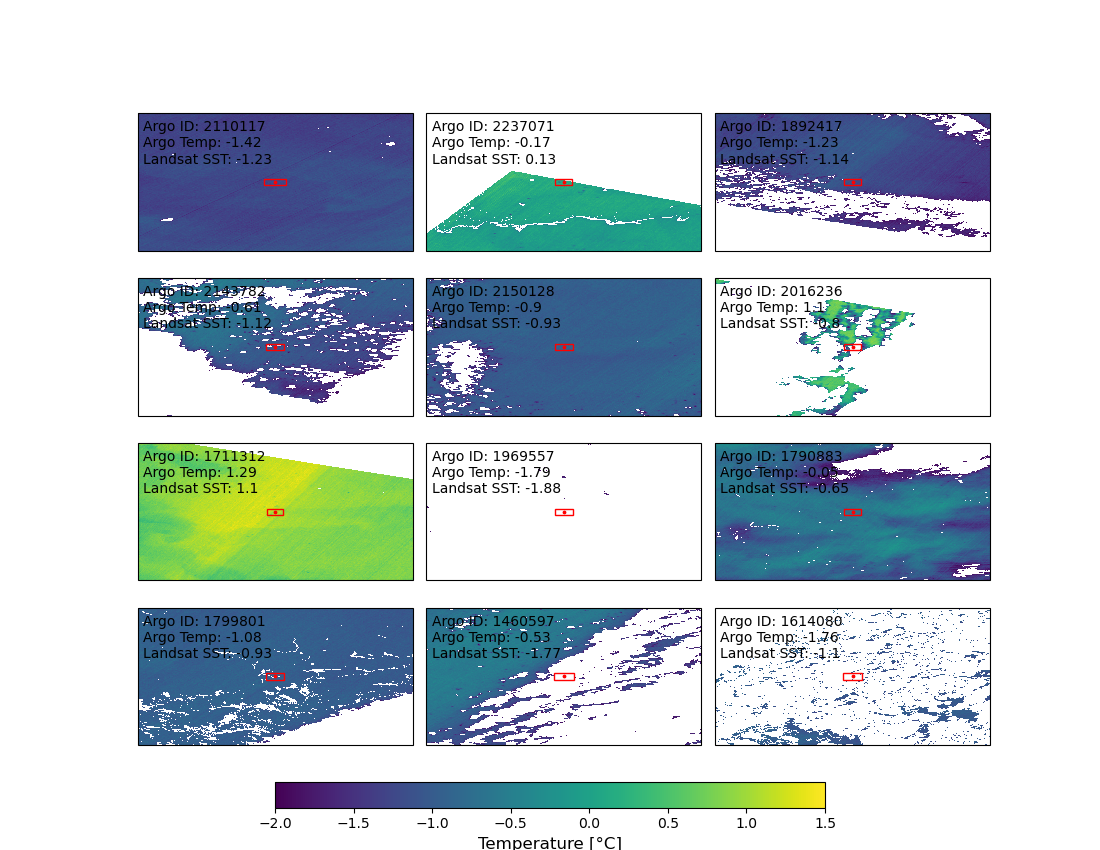

In [48]:
# Number of columns/rows for subplots
n_cols = 3
n_rows = 4

# Create one figure and a 4x7 grid of subplots
# The figsize is 10 across; adjust height as needed for clarity
fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(11, 8.5),   
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Optional: if you want them *really* close, you can fine-tune spacing:
plt.subplots_adjust(wspace=0.05, hspace=0.03)
# plt.subplots_adjust(bottom=0.15)

# Counter for subplot index, and a handle to store the last "imshow" (for colorbar)
i = 0
im_obj = None

for lsatfile in lsatfiles:
    lsID = lsatfile
    print(lsID)
    
    mrow = valids[valids['L8_filename'].str.contains(lsatfile[:-15])]
    
    for idx, row in mrow.iterrows():
        # Check if L8_SST is NaN
        if pd.isnull(row['L8_SST']):
            # If it is NaN, skip this iteration and do not plot
            continue
        
        # --- Prepare data and coordinates ---
        ilat = row['A_lat']
        ilon = row['A_lon']
        
        lat_add = km_to_decimal_degrees(dist, ilat, direction='latitude')
        lon_add = km_to_decimal_degrees(dist, ilat, direction='longitude')
        xmin, ymin, xmax, ymax = (ilon - lon_add, ilat - lat_add, 
                                  ilon + lon_add, ilat + lat_add)
        
        # Load the Landsat file
        ds = xr.open_dataset(lsatfile, chunks=dict(x=512, y=512), engine='rasterio')
        ls_scene = ds['band_data'].sel(band=1).rio.write_crs("epsg:3031", inplace=True)
        
        # Assign time coordinate
        times = pd.to_datetime(lsatfile[17:25] + lsatfile[41:47], format='%Y%m%d%H%M%S')
        ls_scene = ls_scene.assign_coords(time=times, ID=lsatfile[:-8])
        
        # Reproject to EPSG:4326
        ls_scene = ls_scene.rio.reproject("EPSG:4326")

        # Calibrate using MODIS
        ls_scene = ls_scene * calib_m + calib_b

        # Remove all pixels that are too cold
        ls_scene = ls_scene.where(ls_scene>=lthresh,np.nan)
        
        # Select the subplot axis
        ax = axes[i // n_cols, i % n_cols]
        
        # Plot on that axis, without a colorbar
        # Store the "imshow" result in im_obj so we can build one colorbar later
        im_obj = ls_scene.plot.imshow(
            x='x', y='y',
            vmin=-2.0, vmax=1.5,
            ax=ax,
            transform=ccrs.PlateCarree(),
            origin='upper',
            add_colorbar=False  # <- No individual colorbar
        )
        
        # Remove titles completely (xarray may add one by default)
        ax.set_title('')
        
        # Set extent
        ax.set_extent([ilon - 0.4, ilon + 0.4, ilat - 0.2, ilat + 0.2], crs=ccrs.PlateCarree())
        
        # Argo observation
        ax.scatter([ilon], [ilat], c='r', s=3, transform=ccrs.PlateCarree(), label='Argo location')
        
        # Draw bounding box
        polygon_show = Pgon([(xmin, ymin), (xmin, ymax), 
                             (xmax, ymax), (xmax, ymin)],
                            closed=True, edgecolor='red', facecolor='none')
        ax.add_patch(polygon_show)
        
        # Text label
        text_str = (
            f"Argo ID: {row['Argo_id']}\n"
            f"Argo Temp: {np.around(row['Argo_SST'], 2)}\n"
            f"Landsat SST: {np.around(row['L8_SST'], 2)}"
        )
        ax.text(
            0.02, 0.95,
            text_str,
            transform=ax.transAxes,
            fontsize=10,
            va='top',
            ha='left'
        )

        gc.collect()
        
        # Move to next subplot index
        i += 1
        

# --- Add a single colorbar for the entire figure ---
# We use the last "imshow" (im_obj) and attach to all subplot axes
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])

cbar = fig.colorbar(
    im_obj, 
    ax=axes.ravel().tolist(),  # or just ax=axes if axes is 2D
    cax=cbar_ax,
    orientation='horizontal',  # 'vertical' or 'horizontal'
    fraction=0.025,            # how long the colorbar is relative to axes
    pad=0.05                   # space between colorbar and subplots
)
cbar.set_label("Temperature [°C]", fontsize=12)

# plt.tight_layout()
plt.show() 

## Plot high and low quality validation data

In [44]:
# Remove low quality validation data from the valids data
rm_ids = [1460597, 1614080, 2143782, 2016236, 1790883]
rm = validmn[validmn.index.isin(rm_ids)]
validmn = validmn.drop(index=rm_ids, errors='ignore')
valids = valids[~valids['Argo_id'].isin(rm_ids)]

In [45]:
# Orthoganal Regression 
data = validmn

# Original data
x_original = np.array(data['Argo_SST'])
y_original = np.array(data['L8_SST'])

# Define a linear function for the model
def linear_model(p, x):
    return p[0] * x + p[1]

# Create a Model
linear = Model(linear_model)

# Create a RealData object using your DataFrame
data = RealData(x_original, y_original)

# Set up ODR with the model and data
odr = ODR(data, linear, beta0=[1., 0.])

# Run the regression
out = odr.run()

# Use the output
beta = out.beta
beta_err = out.sd_beta

# Print the summary
out.pprint()

# Predicting values using the ODR model
y_pred = linear_model(beta, x_original)

# Get R2
# Calculate Total Sum of Squares (SST)
y_mean = np.mean(y_original)
SST = np.sum((y_original - y_mean)**2)

# Calculate Residual Sum of Squares (SSR)
SSR = np.sum((y_original - y_pred)**2)

# Compute RMSE
rmse = np.sqrt(((y_original - y_pred) ** 2).mean())

# Calculate R^2
R2 = 1 - (SSR / SST)
print("R^2:", np.around(R2,2))
print(f"RMSE: {np.around(rmse,2)}")

Beta: [0.9604976  0.03009098]
Beta Std Error: [0.07105586 0.08645468]
Beta Covariance: [[0.30276779 0.22923813]
 [0.22923813 0.44821559]]
Residual Variance: 0.01667593078822475
Inverse Condition #: 0.06470993032016736
Reason(s) for Halting:
  Sum of squares convergence
R^2: 0.97
RMSE: 0.15


At 95% confidence interval: 0.96+/-0.14, 0.03+/-0.17, n=7


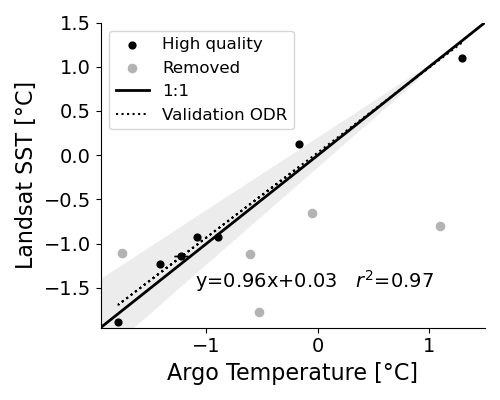

In [46]:
beta_mdn = [beta[0]-beta_err[0]*1.96,beta[1]-beta_err[1]*1.96]
beta_mup = [beta[0]+beta_err[0]*1.96,beta[1]-beta_err[1]*1.96]
beta_bdn = [beta[0]-beta_err[0]*1.96,beta[1]+beta_err[1]*1.96]
beta_bup = [beta[0]+beta_err[0]*1.96,beta[1]+beta_err[1]*1.96]
print(f'At 95% confidence interval: {np.around(beta[0],2)}+/-{np.around(beta_err[0]*1.96,2)}, {np.around(beta[1],2)}+/-{np.around(beta_err[1]*1.96,2)}, n={y_pred.shape[0]}')
xfill = np.array([-4.3,0.9])


# Plot data points and 1:1 line
fig, ax = plt.subplots(figsize=(5, 4))
ax.tick_params(labelsize=14)

xi = np.arange(-7.0,5.0,1.0)

# lower_err = abs(data['L8_SST'] - data['L8_SST_min'])  # distance to lower bound
# upper_err = abs(data['L8_SST_max'] - data['L8_SST'])  # distance to upper bound

ax.scatter(x_original,y_original,color='k',linewidth=0,s=35,label='High quality')
ax.errorbar(x_original,y_original,yerr=validmn['std'],color='k',fmt='o',ecolor='k',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
# ax.errorbar(data['Argo_SST'],data['L8_SST'],yerr=[lower_err,upper_err],color='k',fmt='o',ecolor='k',elinewidth=1,capthick=1,marker='o',ms=3,capsize=5,label='_no legend_')
# ax.scatter(data['Argo_SST'],data['center'],color='r',linewidth=0,s=25,label='_no label_')
ax.scatter(rm['Argo_SST'],rm['L8_SST'],color='0.7', s=35, label='Removed',zorder=2)
ax.plot(xi,xi,color='k',linewidth=2, label='1:1')
ax.plot(x_original, y_pred, color='k', ls=':', label='Validation ODR')
ax.fill_between(xfill, linear_model(beta_bdn, xfill), linear_model(beta_mup, xfill),alpha=0.1, facecolor='0.3')
# a1.plot(xi,xi*lreg.coef_[0]+lreg.intercept_[0],color='r',linewidth=2,label='RANSAC regression')
# a1.scatter(xC,yLC,color='r',linewidth=0,s=35,label='_no label_')
# a1.plot(xi,xi*resultC.params.L8_SST+resultC.params.Intercept,color='k',linewidth=2,label='OLS regression')
# a1.text(-2.1,-2.85,f'y={np.around(resultC.params.L8_SST,2)}x+{np.around(resultC.params.Intercept,2)}   p={p_val}',fontsize=12)
ax.text(-1.1,-1.5,f'y={np.around(beta[0],2)}x+{np.around(beta[1],2)}   $r^2$={np.around(R2,2)}',fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([-1.95,1.5])
ax.set_xlim([-1.95,1.5])
ax.set_xlabel('Argo Temperature [°C]',fontsize=16)
ax.set_ylabel('Landsat SST [°C]',fontsize=16)
ax.legend(markerscale=1,fontsize=12,loc='upper left')

plt.tight_layout()
# plt.savefig('/Users/tsnow03/GoogleDrive/User/Docs/PhD_Project/Manuscripts/AmundsenCC_Manuscript/Figures/LMCalibration.jpg', format='jpg', dpi=1000)
plt.show()